In [2]:
try:
    import skfda 
    # Il y avait une autre implémentation plus simple à utiliser ici https://fuzzy-c-means.readthedocs.io/en/latest/examples/00%20-%20Basic%20clustering/
    # Y'aurait pas eu besoin des FDataGrid chelou dommaJ
except ImportError:
    %pip install -q scikit-fda
    pass
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from utils import generate_blobs, generate_elongated, generate_outliers, experim, plot_data_with_label, plot_3D

## Question 1 : $c$-moyennes floues et possibilistes
### $c$-moyennes floues

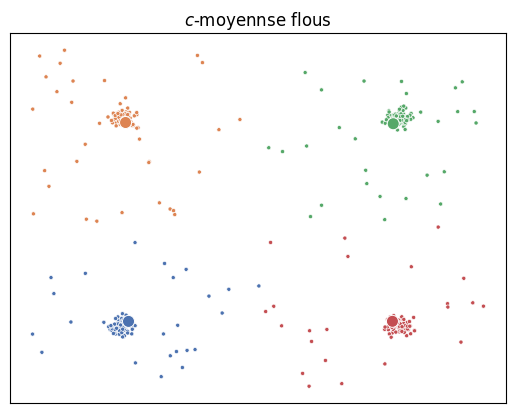

In [3]:
import pandas as pd

class FuzzyCMeans:
    def __init__(self, n_clusters=2, max_iter=200, m=2):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.centroids_ = None
        self.membership_weights_ = None

    def fit(self, df):
        # Initialize variables
        n, d = df.shape
        self.membership_weights_ = self._initializeMembershipWeights(n, self.n_clusters)

        for _ in range(self.max_iter):
            self.centroids_ = self._computeCentroids(df, self.membership_weights_, d)
            self.membership_weights_ = self._updateWeights(df, self.membership_weights_, self.centroids_)

    def predict(self, df):
        return self.predict_proba(df).argmax(axis=1)
    
    def predict_proba(self, df):
        # Check if the model is fitted
        if self.centroids_ is None:
            raise Exception("Model is not fitted yet.")
        
        # Initialize variables
        n, d = df.shape
        membership_weights_ = self._initializeMembershipWeights(n, self.n_clusters)
        
        return self._updateWeights(df, membership_weights_, self.centroids_)

    def _initializeMembershipWeights(self, n, k):
        weight = np.random.dirichlet(np.ones(k), n)
        return np.array(weight)

    def _computeCentroids(self, df, weight_arr, d):
        C = []
        for i in range(self.n_clusters):
            weight_sum = np.power(weight_arr[:, i], self.m).sum()
            Cj = [(df.iloc[:, x].values * np.power(weight_arr[:, i], self.m)).sum() / weight_sum for x in range(d)]
            C.append(Cj)
        return np.array(C)

    def _updateWeights(self, df, weight_arr, C):
        n = df.shape[0]
        denom = np.zeros(n)
        for i in range(self.n_clusters):
            dist = np.sqrt(((df - C[i]) ** 2).sum(axis=1))
            denom += np.power(1 / dist, 1 / (self.m - 1))

        for i in range(self.n_clusters):
            dist = np.sqrt(((df - C[i]) ** 2).sum(axis=1))
            weight_arr[:, i] = np.power(1 / dist, 1 / (self.m - 1)) / denom
        return weight_arr

centers = [(-20, -20), (-20, 20), (20, -20), (20, 20)]
cov = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]
n_clusters = len(centers)
X_train, X_outliers = generate_elongated(
    n_samples=300, n_clusters=n_clusters, centers=centers, cov=cov, n_outliers=100
)
X = np.concatenate((X_train, X_outliers))
df = pd.DataFrame(X) # Some DataFrame
fm = FuzzyCMeans(n_clusters=n_clusters, max_iter=200, m=2)
fm.fit(df)
plot_data_with_label(
    X,
    labels_true=fm.membership_weights_.argmax(axis=1),
    cluster_centers=fm.centroids_,
    title='$c$-moyennse flous',
    legend=False
)


### $c$-moyennes possibilistes

array([[-18.38065236,   8.86539538],
       [-18.38065236,   8.86539538],
       [ 16.88038889,  -7.50443874],
       [ 16.88038889,  -7.50443874]])

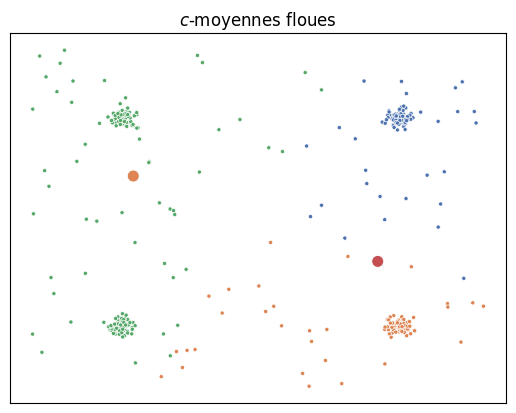

In [4]:
class PossibilisticCMeans(FuzzyCMeans):
    def __init__(self, n_clusters=2, max_iter=200, m=2, eta=None):
        super().__init__(n_clusters, max_iter, m)
        if not eta:
            eta = np.ones((n_clusters,)) - 0.5
        self.eta = eta
    
    def _updateWeights(self, df, weight_arr, C):
        X = df.values
        for i in range(self.n_clusters):
            dist = np.linalg.norm(X - C[i], axis=1)
            weight_arr[:, i] = 1 + np.power( dist / self.eta[i] , 2 / (self.m - 1))
        return weight_arr
df = pd.DataFrame(X) # Some DataFrame
p_cmeans = PossibilisticCMeans(n_clusters=n_clusters, max_iter=500, m=2)
p_cmeans.fit(df)
plot_data_with_label(
    X,
    labels_true=p_cmeans.membership_weights_.argmax(axis=1),
    cluster_centers=p_cmeans.centroids_,
    title='$c$-moyennes floues',
    legend=False
)
p_cmeans.centroids_

Nous constatons que certains clusters fusionnent suite au relâchement de la contrainte sur le degré d'appartenance.

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">
    <strong>Note:</strong> Ce comportement caractéristique du c-moyenne possibiliste se maintient tout au long de ce TME et se reproduit également avec d'autres implémentations. Cela est due à la capacité de l'algorithme à trouver des minimums globaux pour sa fonction de perte. <br/>
    Avec cette particularité, peu de commentaires ont été faits sur ses capacités réelles lors des expérimentations. Comme abordé en cours, le c-moyenne possibiliste est en fait davantage un algorithme de <em>mode-seeking</em>, ce qui lui permet de capturer les outliers ou d'obtenir une meilleure compréhension des données.
</div>

## Question 2 : Comparaison des algorithmes sur des données gaussiens


### Clusters espacés

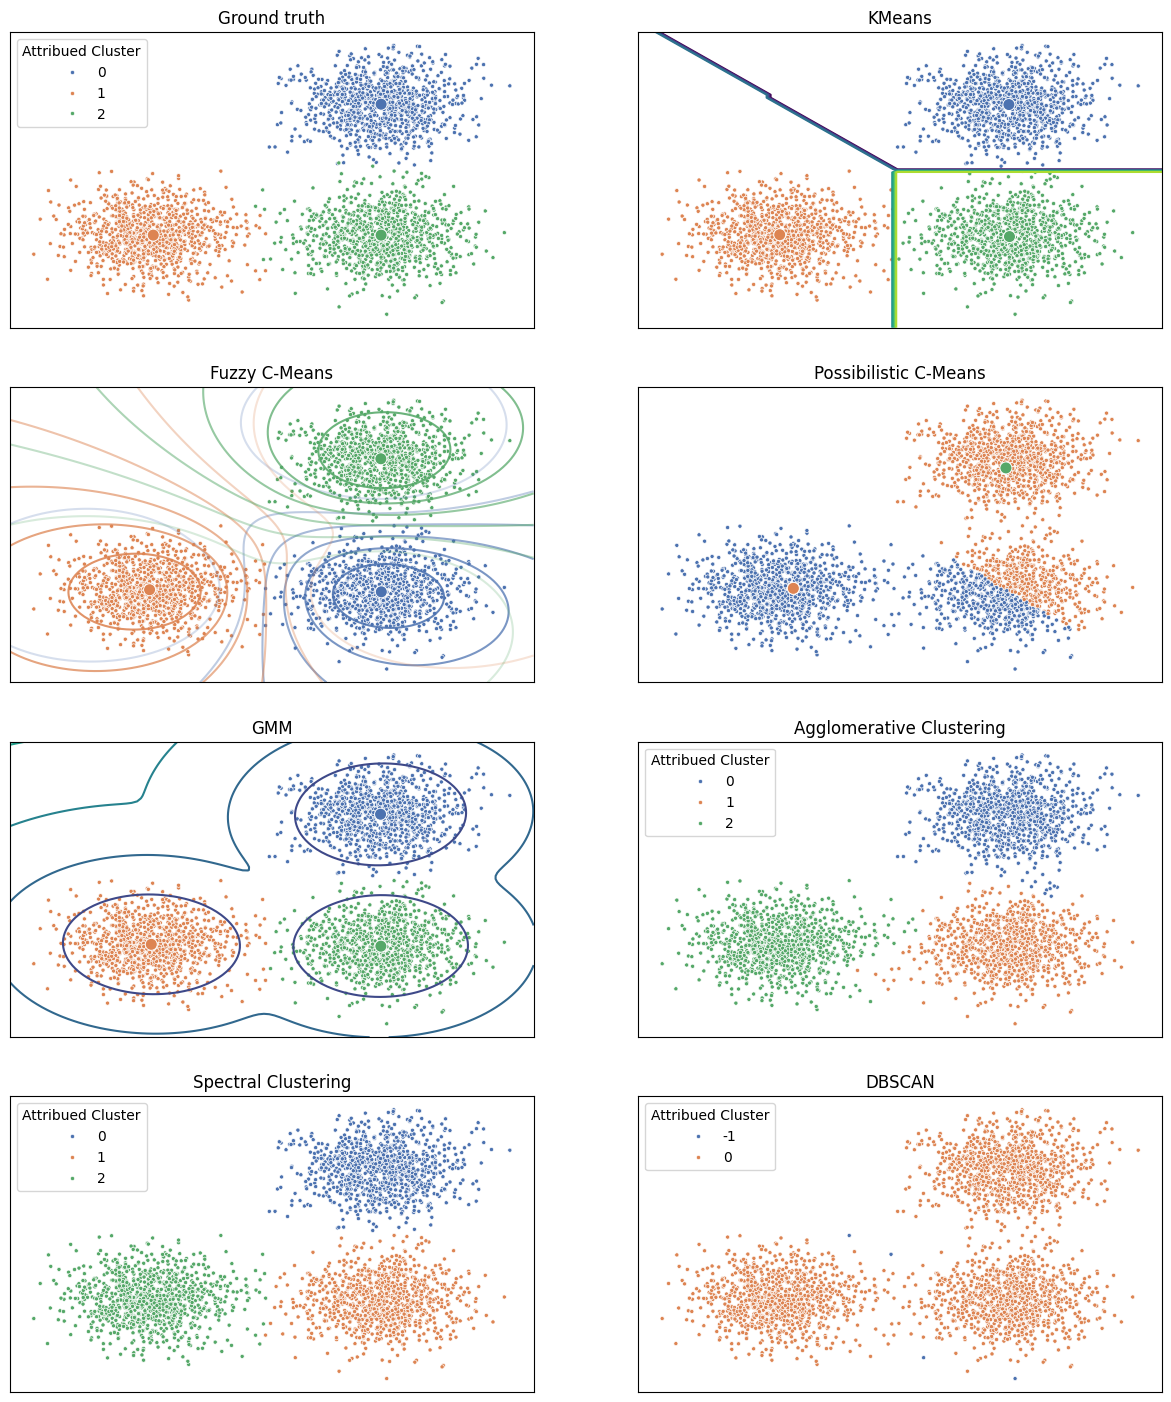

In [5]:
centers = np.array([[2, 2], [-2, -2], [2, -2]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, labels_true, centers)

Dans ce premier exemple, nous observons que tous nos algorithmes, à l'exception de DBSCAN et du $c$-moyenne possibiliste (FCM), réussissent à partitionner notre jeu de données.

Pour DBSCAN, il semble nécessaire d'affiner son hyperparamètre principal, $\varepsilon$.

Les lignes de niveau générées par l'algorithme de c-moyennes floues sont particulièrement intéressantes et méritent une attention plus détaillée.


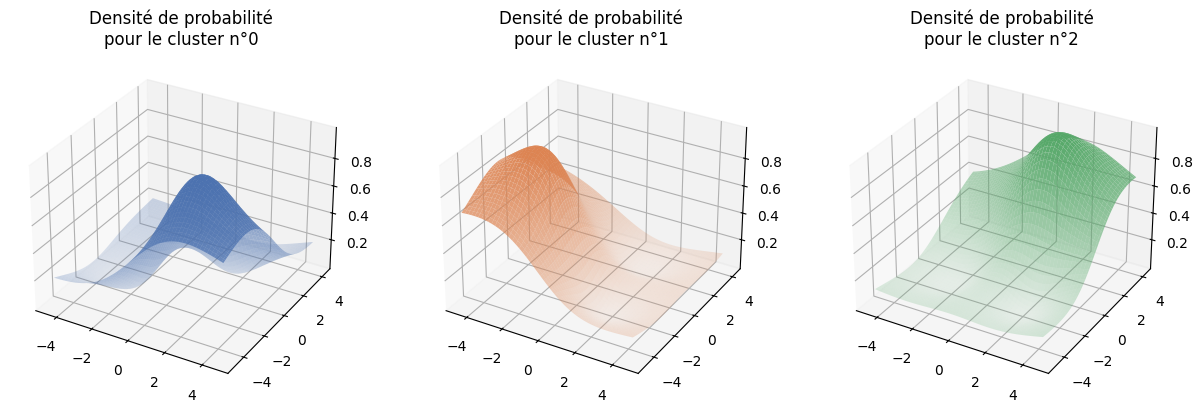

In [6]:
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

On observe que la fonction degré d'appartenance à un cluster forme deux creux, atteignant zéro au niveau des loci des deux autres clusters. La visibilité de ces minima locaux dépend de l'orientation de la fonction ; elle est particulièrement notable sur le graphique où la courbe descend de gauche à droite. Ceci illustre que l'algorithme des c-moyennes floues prend en compte la position des autres clusters dans son calcul.

### Clusters rapprochés

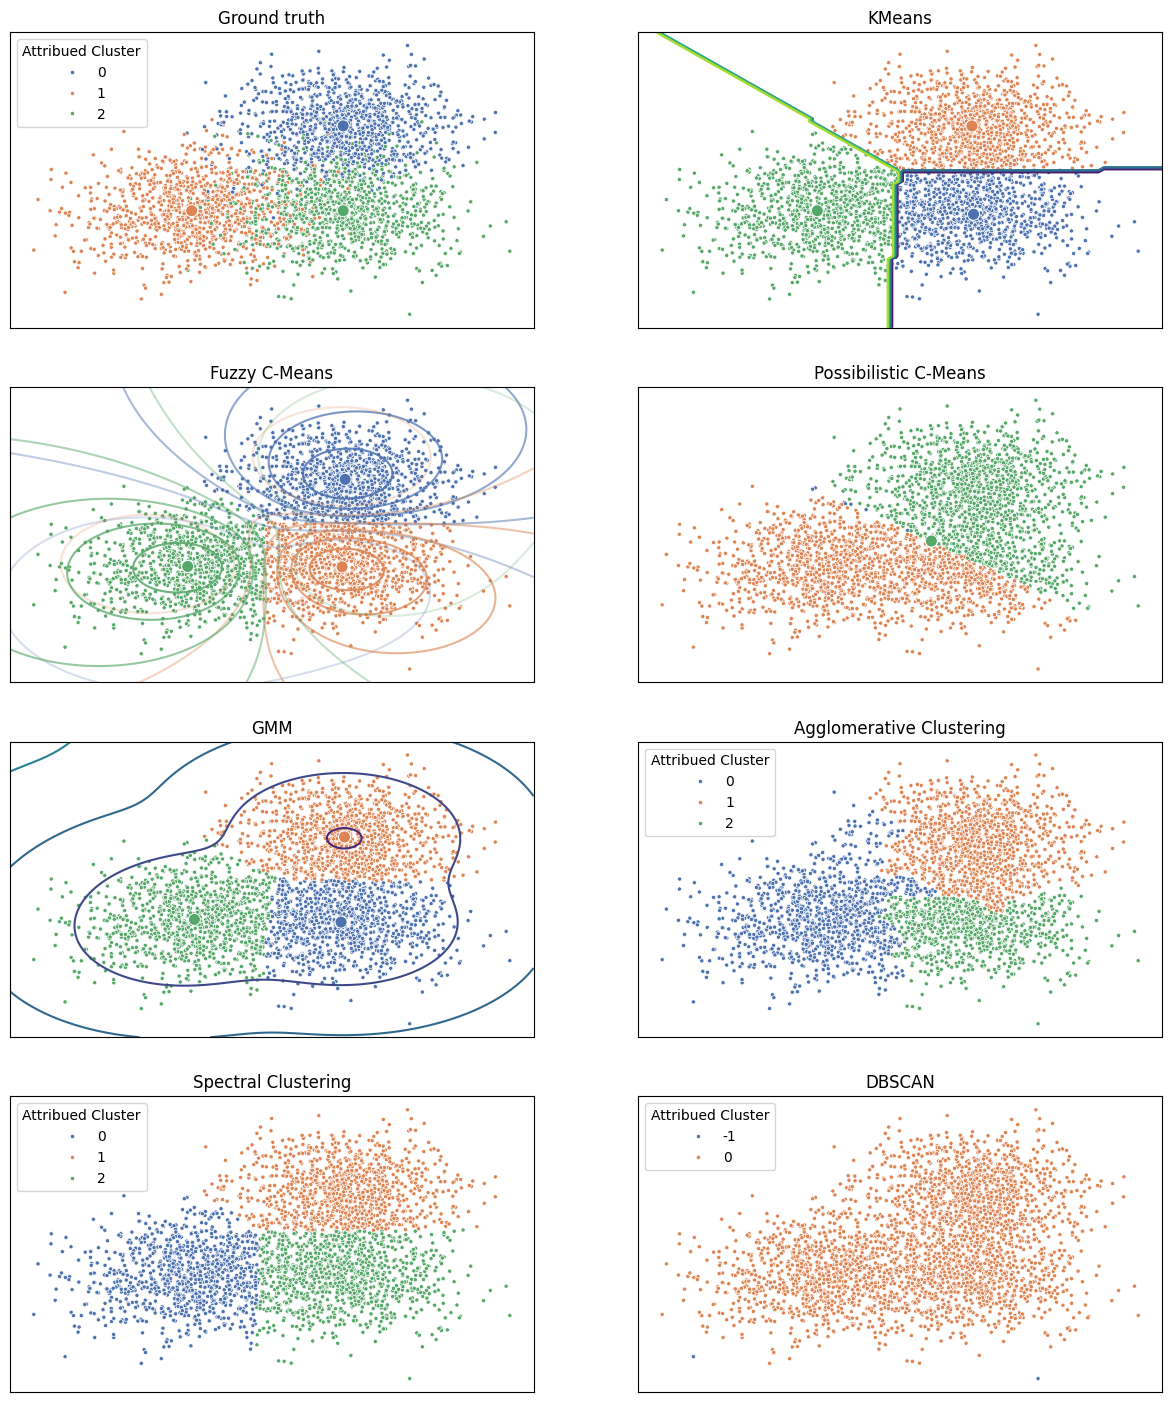

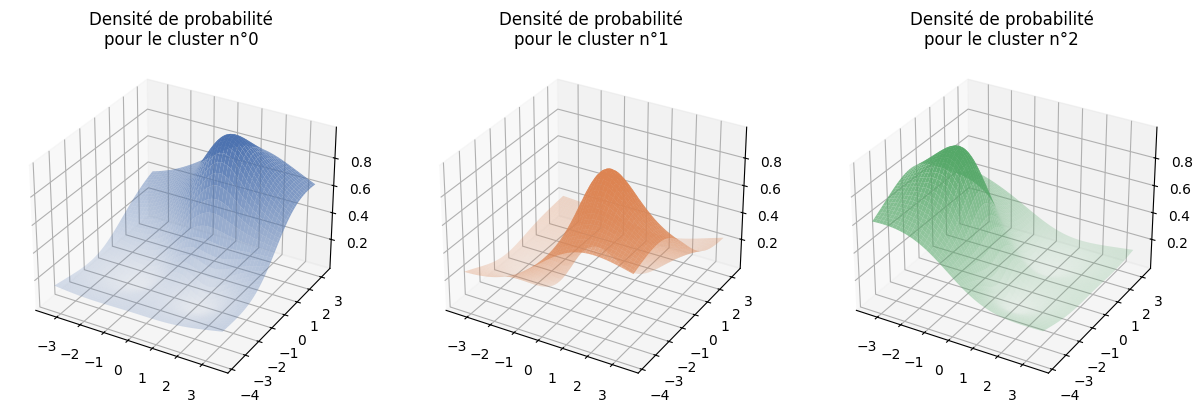

In [7]:
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, labels_true, centers)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

On retrouve le même genre de fonction d'appartenance pour les $c$-moyennes floues que précédement tandis que les résultats du clustering agglomératif sont plus variables.

## Question 3 : Comparaison des résultats sur les données `halfmoon`


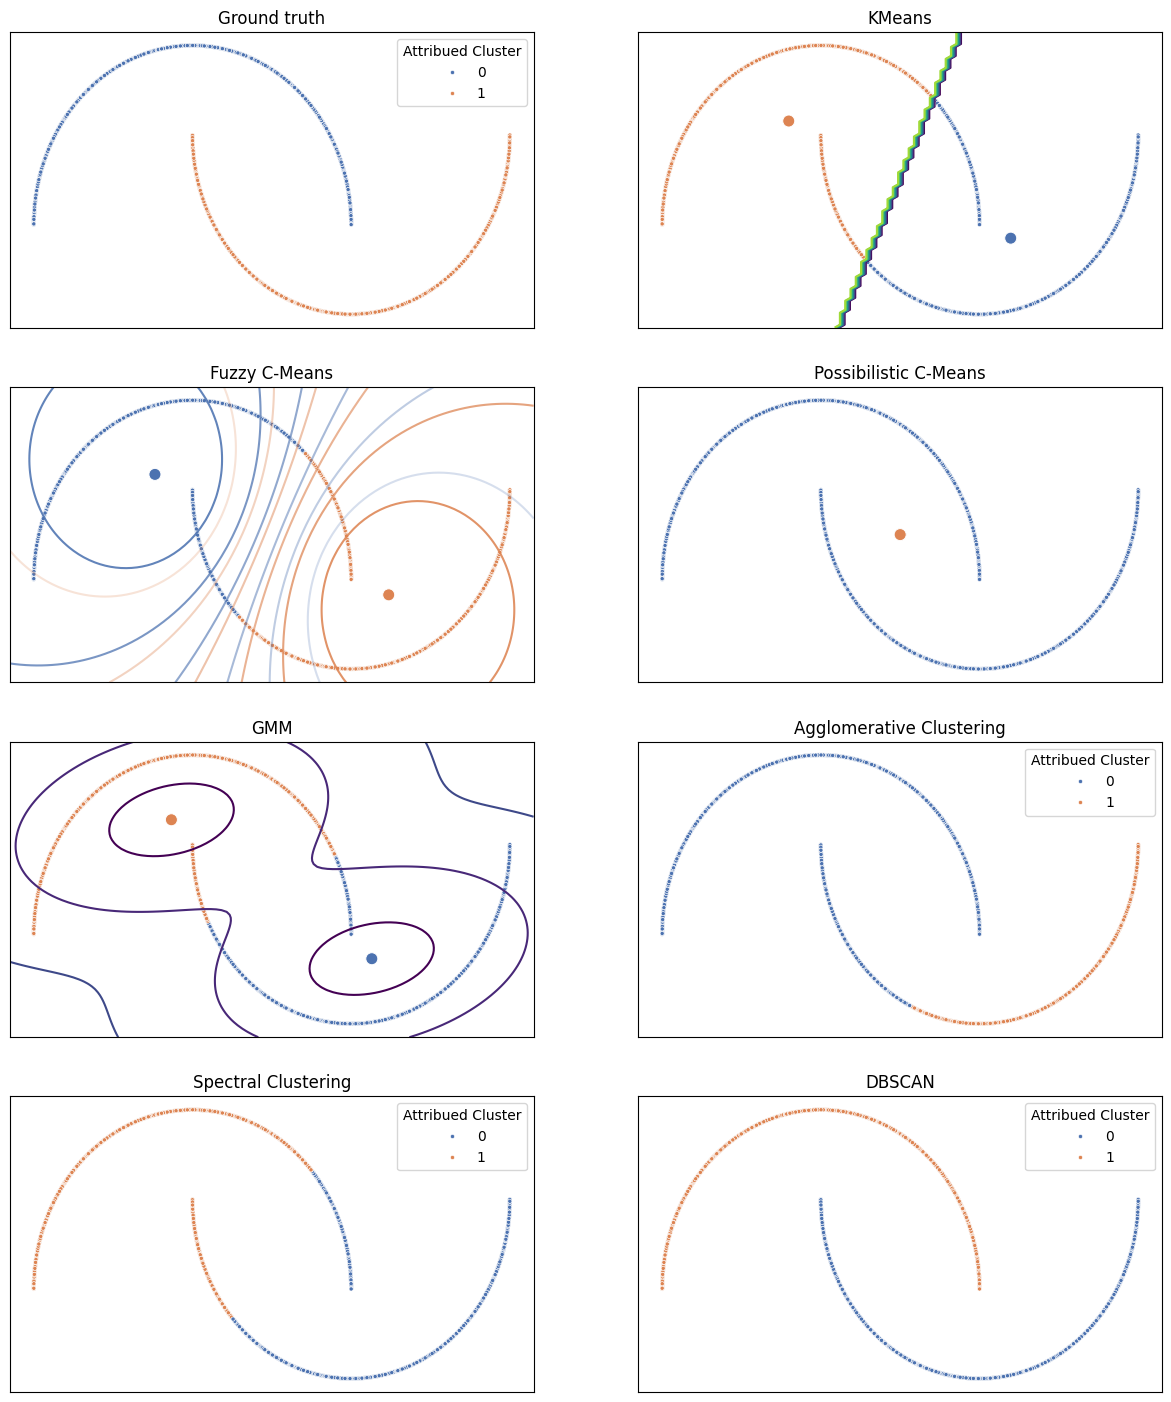

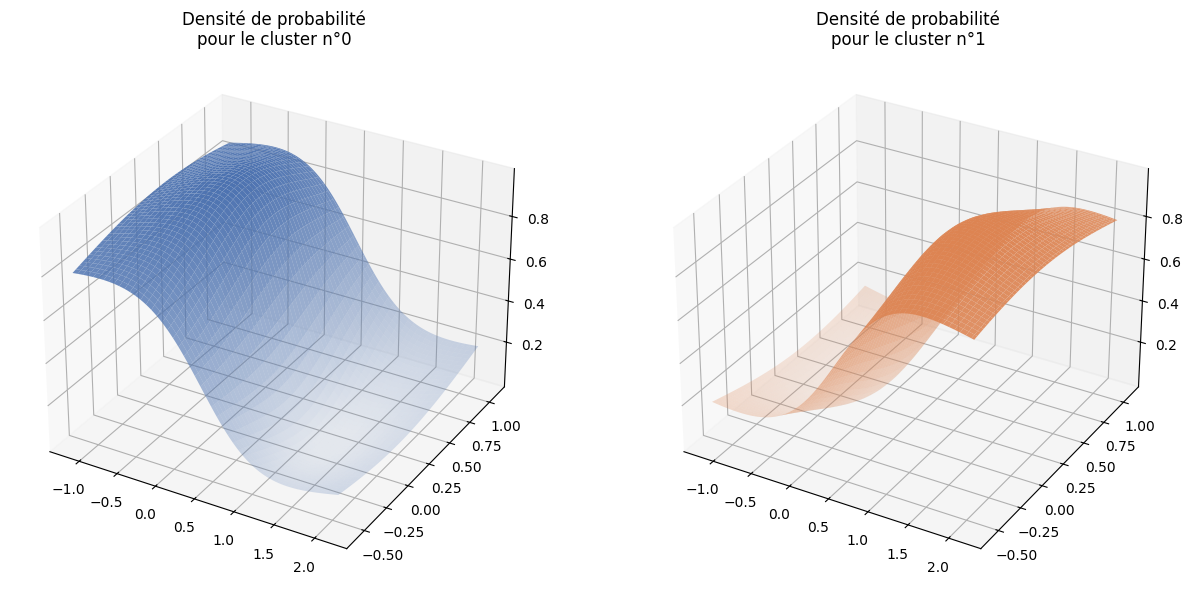

In [8]:
X, labels_true = make_moons(n_samples=3000)
estimators, XX, X_mesh, Y_mesh = experim(X, 2, labels_true)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], 2)

- Le PCM semble ne pas avoir saisi la tâche 😂.
- Le FCM affiche un comportement similaire au K-Means, tout en fournissant une information supplémentaire et intéressante. En examinant les fonctions d'appartenance, on remarque que la probabilité d'appartenance diminue à mesure qu'on se rapproche de la frontière d'un autre cluster.
- DBSCAN réussit brillamment ce test, ce qui est attendu étant donné sa réputation dans ce domaine.

## Question 4 : Tolérance aux outliers


In [9]:
centers = [(-20, -20), (-20, 20), (20, -20), (20, 20)]
cov = [
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[1, 0], [0, 1]]),
]
n_clusters = len(centers)
X_train, X_outliers = generate_elongated(
    n_samples=300, n_clusters=n_clusters, centers=centers, cov=cov
)
obs = np.array([[0, 0]])  # le centre du plan 2D

### Sans outliers : baseline


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


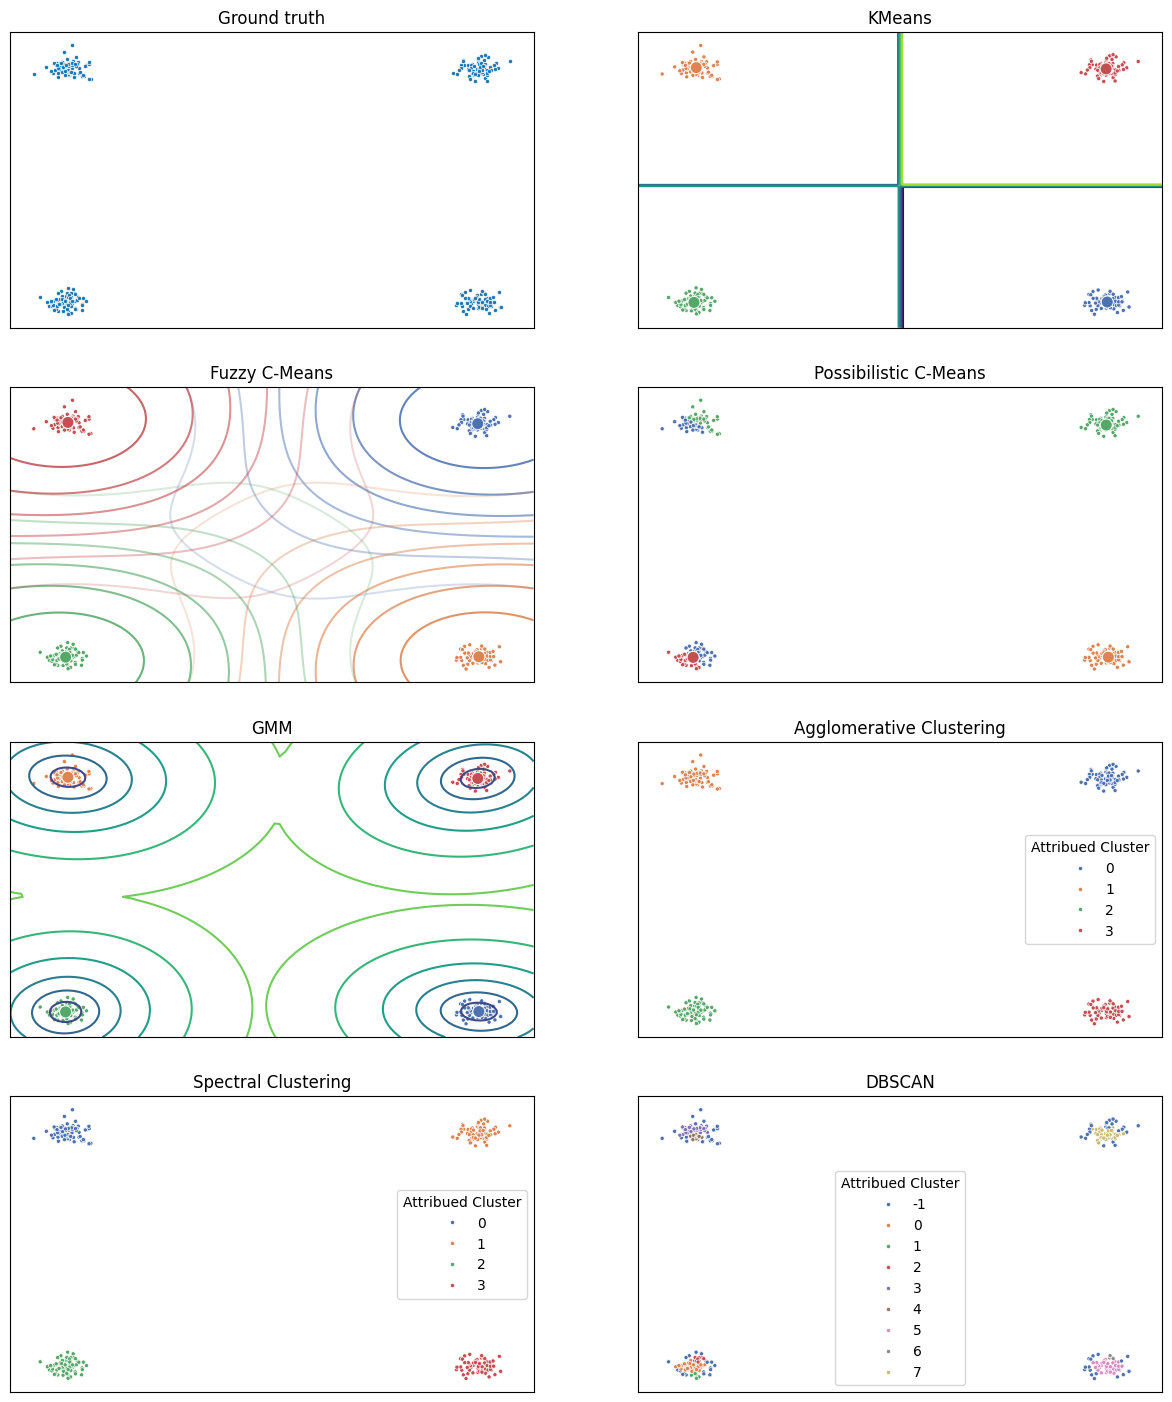

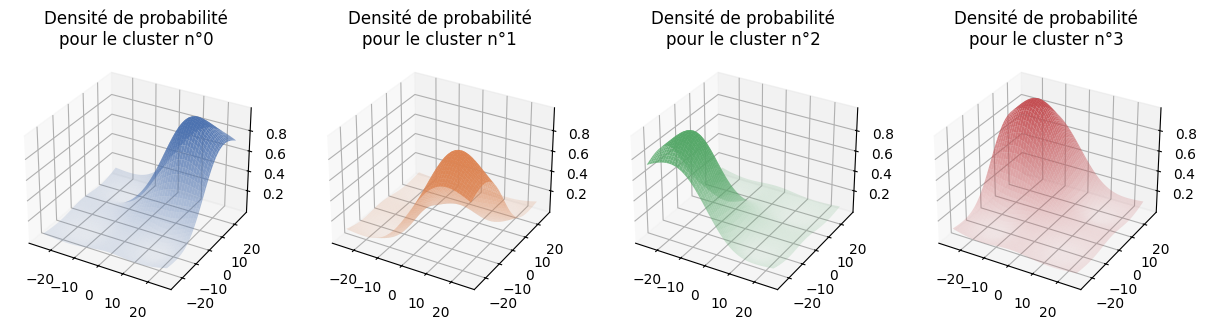

In [10]:
estimators, XX, X_mesh, Y_mesh = experim(X_train, n_clusters)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

Aucun problème avant l'introduction d'outliers. Belle symétrie des densités, que cela soit pour les $c$-moyennes floues ou les GMM.


### Introduction d'outliers


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


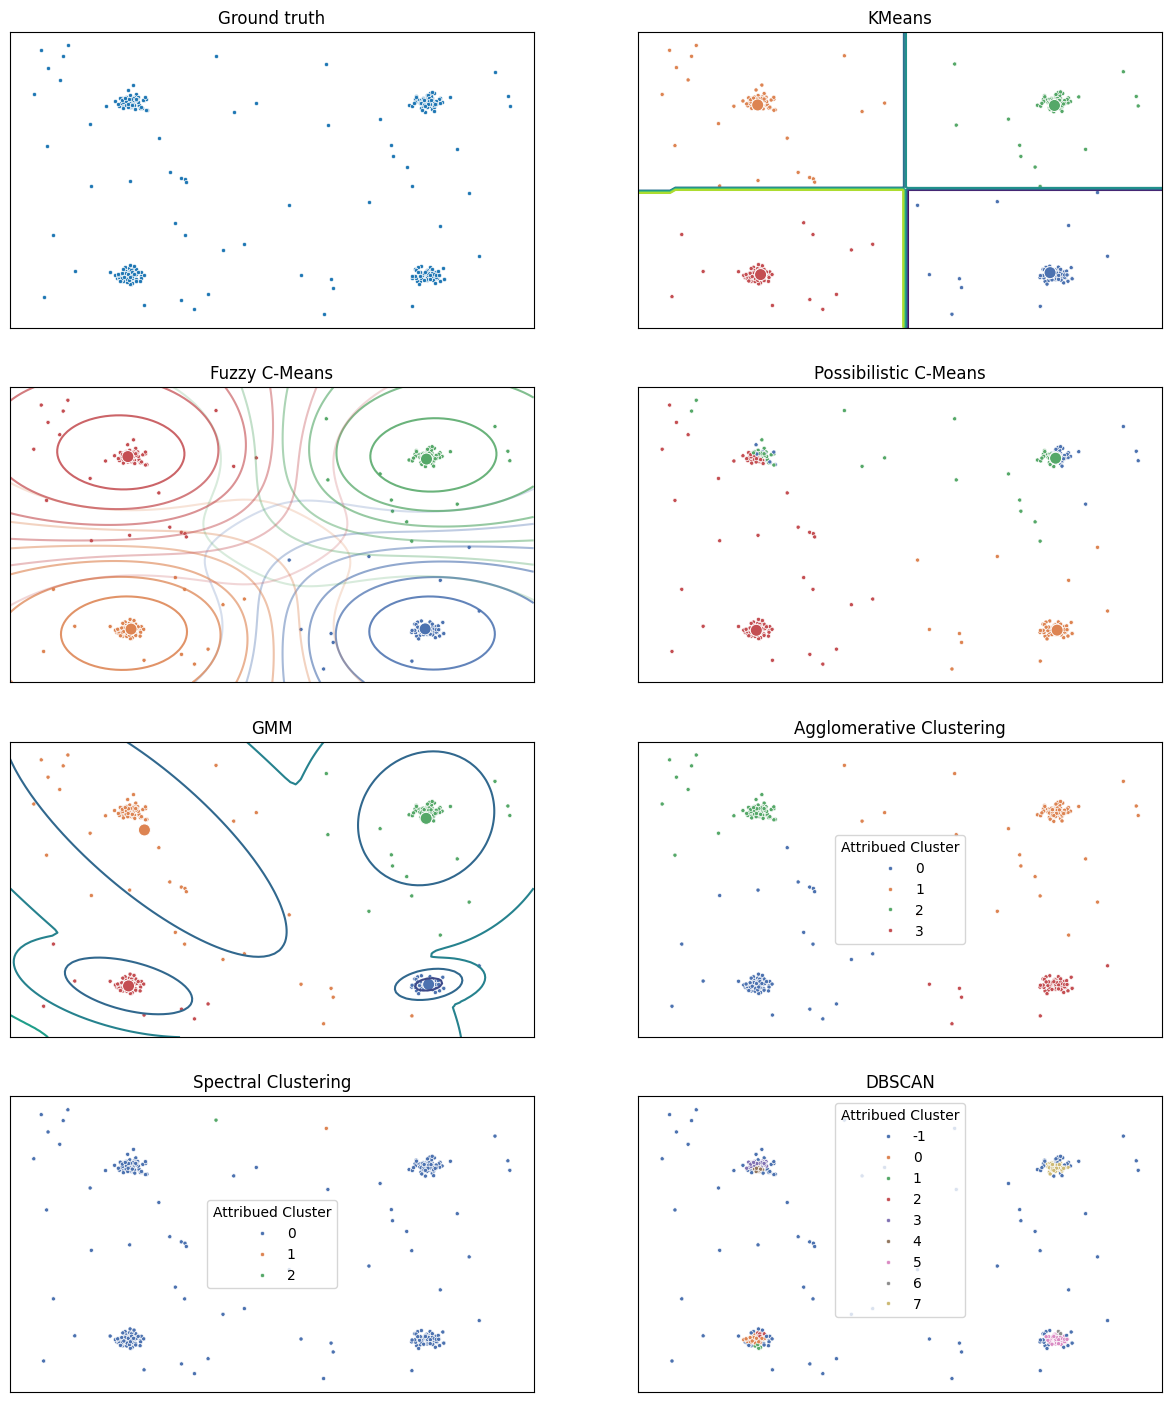

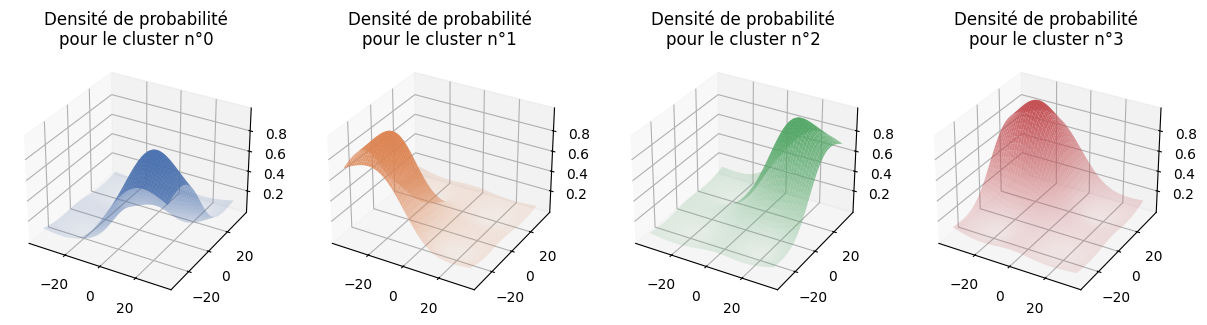

In [11]:
estimators, XX, X_mesh, Y_mesh = experim(
    np.concatenate((X_train, X_outliers), 0), n_clusters
)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

- Les algorithmes des c-moyennes floues et des k-moyennes montrent une bonne résistance face aux outliers.
- Le clustering agglomératif s'en sort également bien, bien que ses frontières soient plus floues comparées à celles obtenues avec les k/c-moyennes.
- Les algorithmes GMM, DBSCAN et le clustering spectral rencontrent des difficultés à gérer correctement l'espace 2D, échouant parfois à identifier le nombre adéquat de clusters.
- Le PCM persiste dans son comportement unique et caractéristique. Curieusement, il ne semble pas gérer efficacement les outliers, ce qui soulève des questions quant à la qualité de son implémentation.


### Pertubation avec une exception ambiguë à tous les clusters


Passons sur uniquement deux clusters :


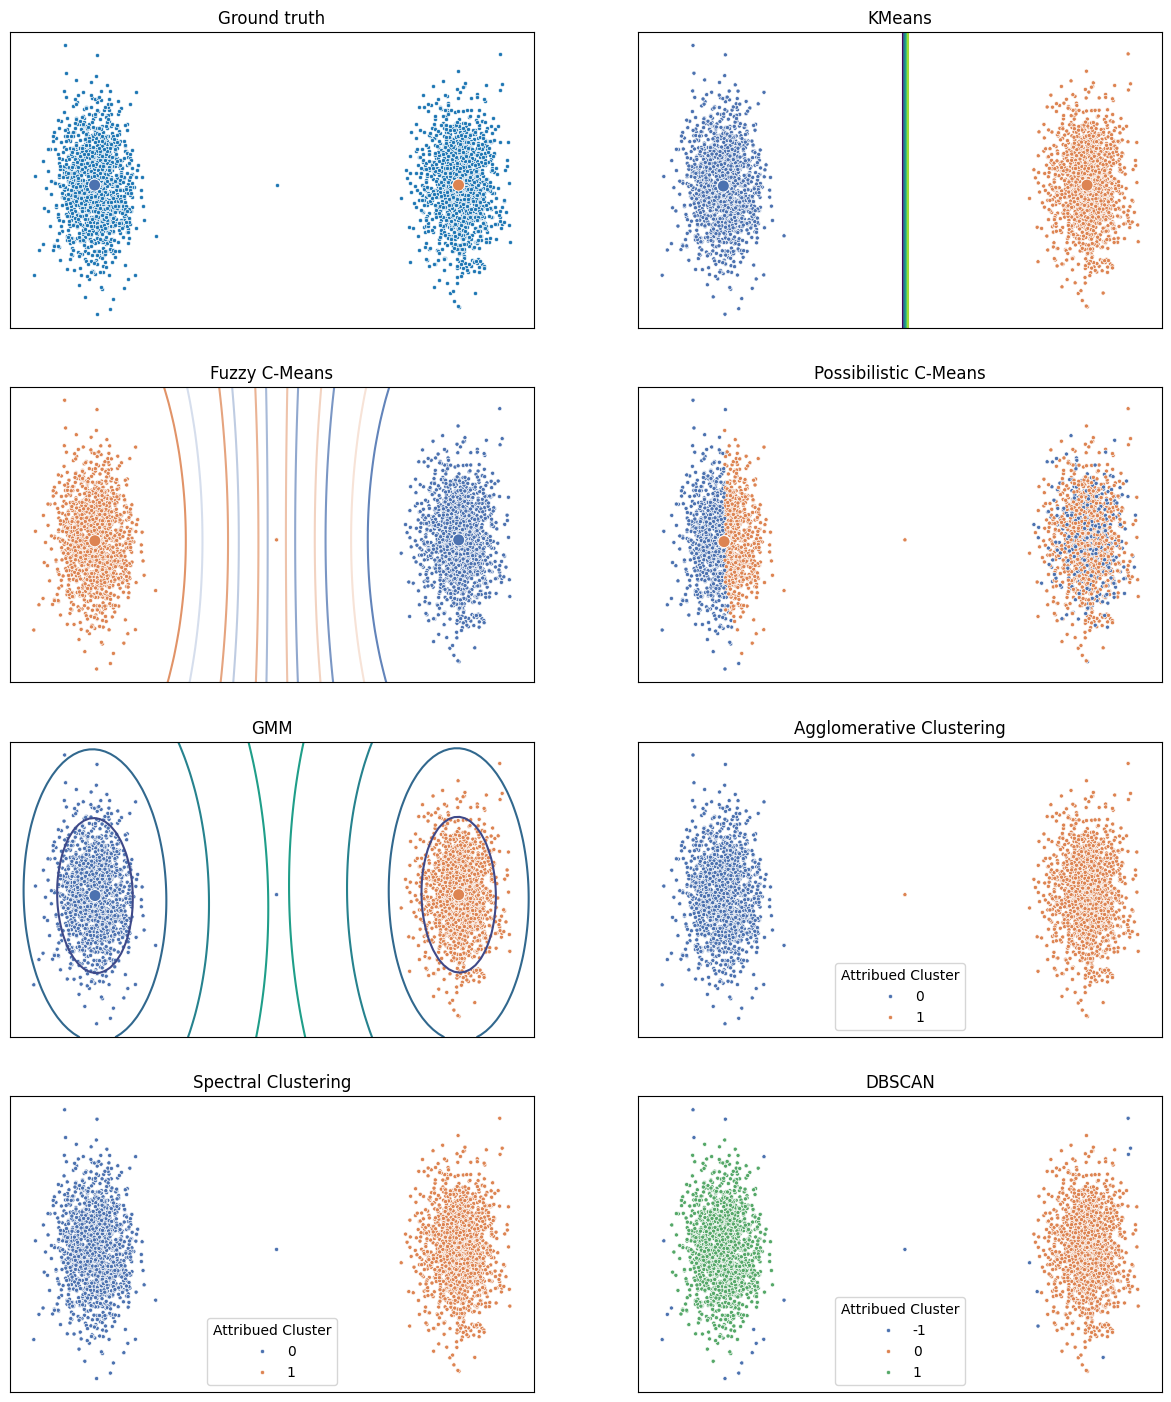

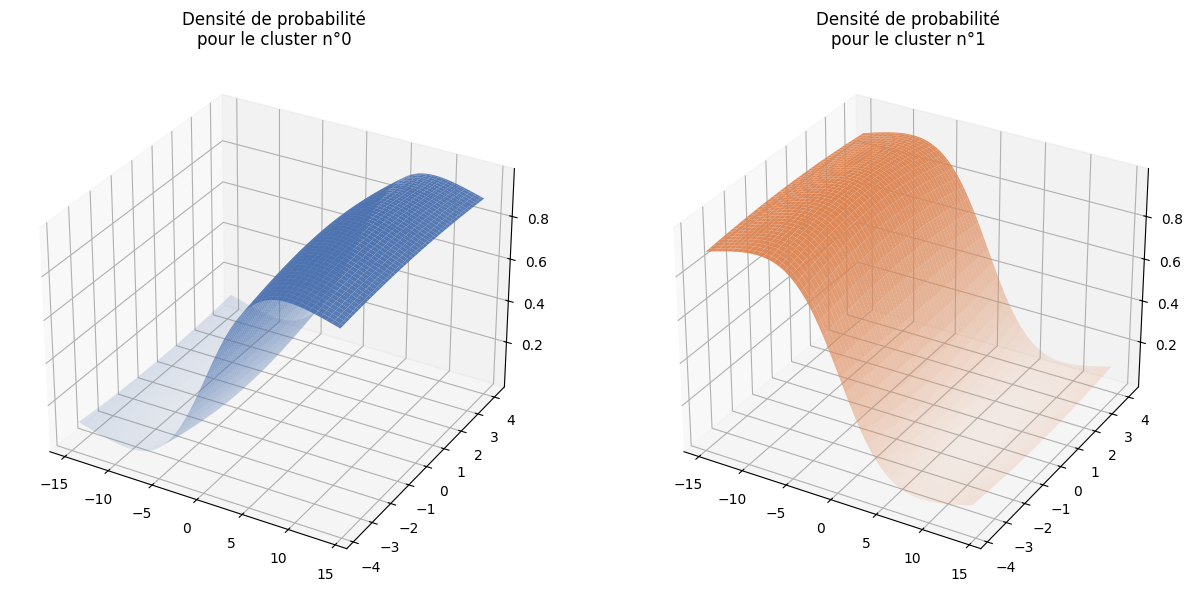

In [12]:
obs = np.array([[0, 0]])  # le centre du plan 2D
centers = np.array([[-10, 0], [10, 0]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=1)
X = np.concatenate((X, obs), 0)
estimators, XX, X_mesh, Y_mesh = experim(X, n_clusters, centers=centers)
plot_3D(XX, X_mesh, Y_mesh, estimators["fuzzy_cmeans"], n_clusters)

Bien que la majorité des algorithmes testés effectuent une classification binaire, il est intéressant d'examiner les probabilités et les degrés d'appartenance aux clusters pour les algorithmes suivants :

In [13]:
from IPython.display import HTML

fuzzy_prob_obs = (
    estimators["fuzzy_cmeans"].predict_proba(skfda.FDataGrid(obs, [0, 1])).squeeze()
)
gmm_prob_obs = estimators["gmm"].predict_proba(obs).squeeze()
display(
    HTML(
        f"""
    <table>
    <tr>
        <td>Degré d&#39;appartenance</td>
        <td>Cluster 1</td>
        <td>Cluster 2</td>
    </tr>
    <tr>
        <td>c-moyenne floue</td>
        <td>{fuzzy_prob_obs[0]}</td>
        <td>{fuzzy_prob_obs[1]}</td>
    </tr>
    <tr>
        <td>GMM</td>
        <td>{gmm_prob_obs[0]:.2f}</td>
        <td>{gmm_prob_obs[1]:.2f}</td>
    </tr>
</table>
    """
    )
)

C'est dans ce genre de cas que l'on voit que les $c$-moyennes floues n'indiquent pas une probabilité. En effet, la motivation à l'origine des $c$-moyennes floues était de pouvoir traiter les cas ambigus en permetant un chevauchement des clusters. Pour cette algorithme, le point appartient à part égale au deux clusters.

Pour le GMM, on voit que le point n'appartient pas à part égal aux deux clusters : l'algorithme fait un choix pour la classification de ce point ambigu.


## Question 5 : Stabilité


100%|██████████| 3000/3000 [01:03<00:00, 47.23it/s]


<Axes: title={'center': 'Distribution de la précision\npour $c$-moyennes floues'}, xlabel='Accuracy', ylabel='Count'>

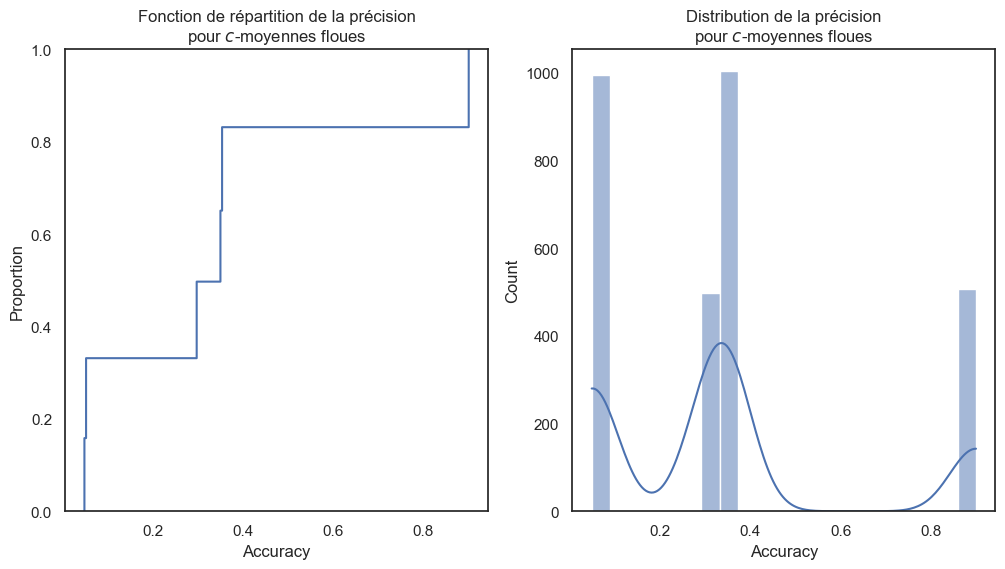

In [114]:
from tqdm import tqdm
import seaborn as sns
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    fuzzy_cmeans = skfda.ml.clustering.FuzzyCMeans(
        n_clusters=n_clusters, n_init=1, random_state=np.random.randint(0, 100000)
    )
    fuzzy_cmeans.fit(fd)
    yhat = fuzzy_cmeans.predict(fd)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $c$-moyennes floues")
ax2.set_title("Distribution de la précision\npour $c$-moyennes floues")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

100%|██████████| 3000/3000 [00:16<00:00, 187.32it/s]


<Axes: title={'center': 'Distribution de la précision\npour $k$-moyenne'}, xlabel='Accuracy', ylabel='Count'>

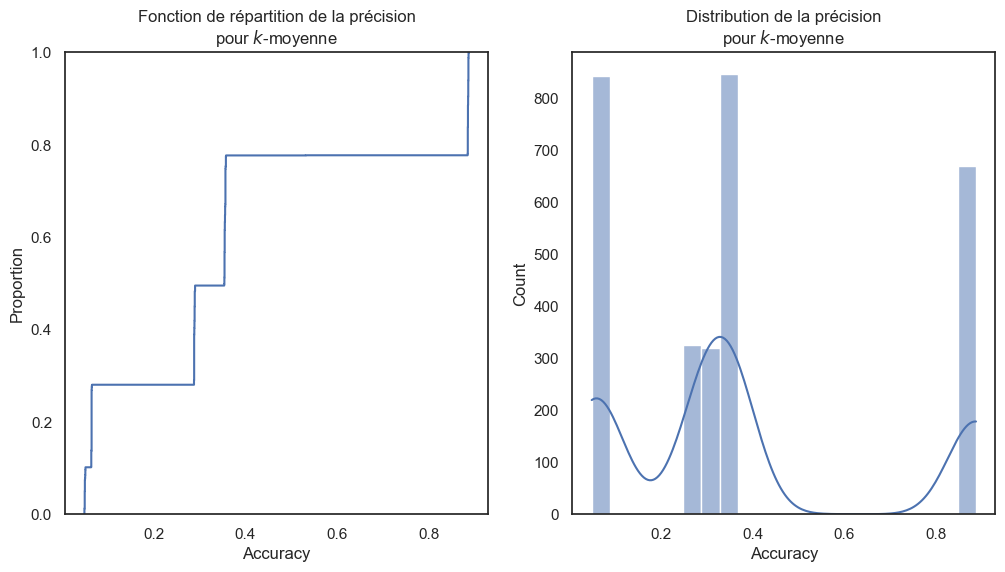

In [113]:
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    k_means = KMeans(n_clusters=n_clusters, n_init=1, random_state=np.random.randint(0, 100000)).fit(X)
    yhat = k_means.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $k$-moyenne")
ax2.set_title("Distribution de la précision\npour $k$-moyenne")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

En ajustant le paramètre `n_init`, nous constatons une importante variance dans les performances de l'algorithme des c-moyennes floues, comme illustré dans la première figure. Cette variabilité semble héritée de sa version non floue, montrée dans la deuxième figure.

Explorons maintenant l'effet de différentes initialisations des centres sur ces performances.

100%|██████████| 500/500 [10:05<00:00,  1.21s/it]


<Axes: title={'center': 'Distribution de la précision\npour $c$-moyennes floues'}, xlabel='Accuracy', ylabel='Count'>

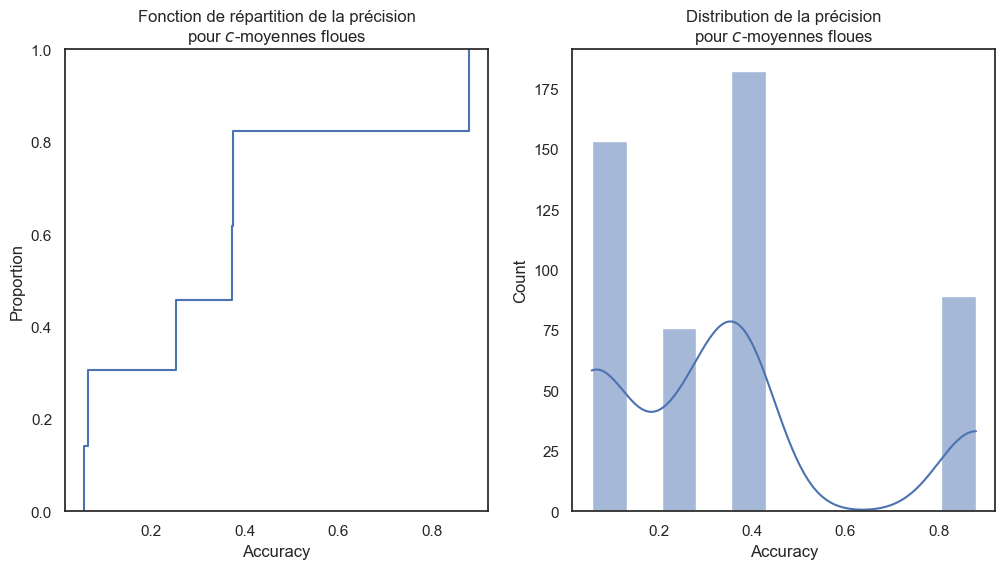

In [118]:
from tqdm import tqdm
import seaborn as sns
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=0.7)
X = pd.DataFrame(X)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(500)):
    fuzzy_cmeans = FuzzyCMeans(n_clusters=n_clusters)
    fuzzy_cmeans.fit(X)
    yhat = fuzzy_cmeans.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $c$-moyennes floues")
ax2.set_title("Distribution de la précision\npour $c$-moyennes floues")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

Au début de ce notebook, notre implémentation des c-moyennes floues utilisait une initialisation des poids basée sur une distribution de Dirichlet. Il semble que cette méthode n'ait pas contribué à réduire la variance dans les résultats.

Pour explorer d'autres pistes, testons maintenant l'initialisation "k-means++" proposée par sklearn pour l'algorithme des k-means.


100%|██████████| 3000/3000 [00:10<00:00, 282.45it/s]


<Axes: title={'center': "Distribution de la précision\npour $k$-moyenne version 'k-mean+'"}, xlabel='Accuracy', ylabel='Count'>

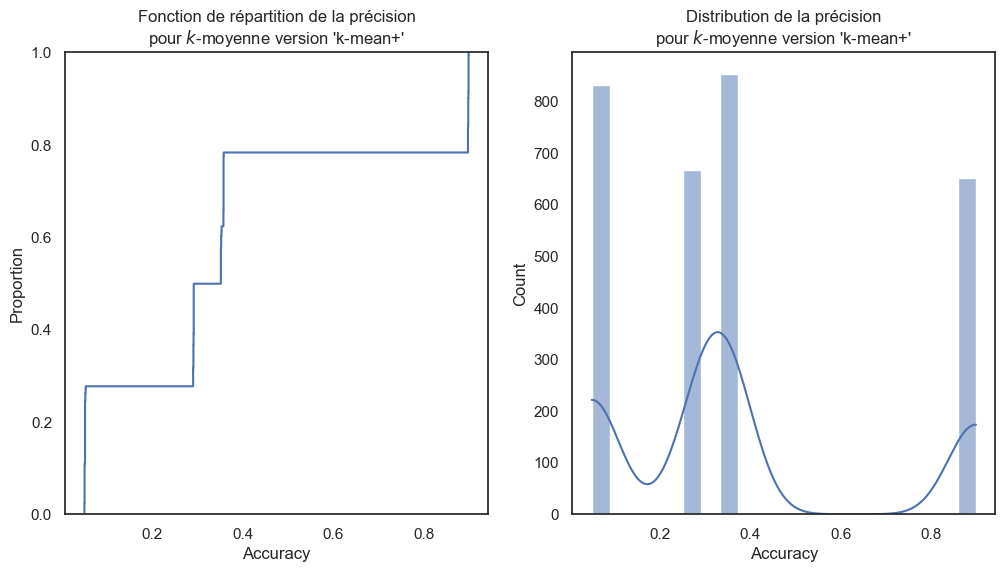

In [127]:
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
centers = np.array([[1, 1], [-1, -1], [1, -1]])
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
n = len(X)
fd = skfda.FDataGrid(X, [0, 1])
acc_list = []
for i in tqdm(range(3000)):
    k_means = KMeans(n_clusters=n_clusters, n_init=1, init="k-means++", random_state=np.random.randint(0, 100000)).fit(X)
    yhat = k_means.predict(X)
    acc = (yhat == labels_true).sum() / n
    acc_list.append(acc)
acc_list = np.array(acc_list)
acc_series = pd.Series(acc_list, name="Accuracy")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*4, 6))
ax1.set_title("Fonction de répartition de la précision\npour $k$-moyenne version 'k-mean+'")
ax2.set_title("Distribution de la précision\npour $k$-moyenne version 'k-mean+'")
sns.ecdfplot(acc_series, ax=ax1)
sns.histplot(acc_series, ax=ax2, kde=True)

L'utilisation de l'initialisation "k-means++" ne semble pas avoir un impact significatif sur la variance du score de précision dans notre étude.